In [2]:
import pennylane as qml
import pennylane.numpy as np
from model import Model

In [3]:
name = 'phong_1_10_parallel'
def func(n, phi):
    return np.cos(phi) ** n
consts = {'ks': 0.5}
scalars = {'n': {'range':(1,10), 'type': np.uint32}}
angles = {'phi': {'range':(0, np.pi / 2)}}

In [4]:
model = Model(name)
model.set_function(func)
# model.set_consts(consts)
model.set_scalars(scalars)
model.set_angles(angles)

model.set_sample_size(500)

try:
	model.read_samples('samples/' + model.name + '.bin')
except FileNotFoundError:
	model.generate_samples()
	model.read_samples('samples/' + model.name + '.bin')

model.separate()

(<Figure size 7500x700 with 1 Axes>, <Axes: >)

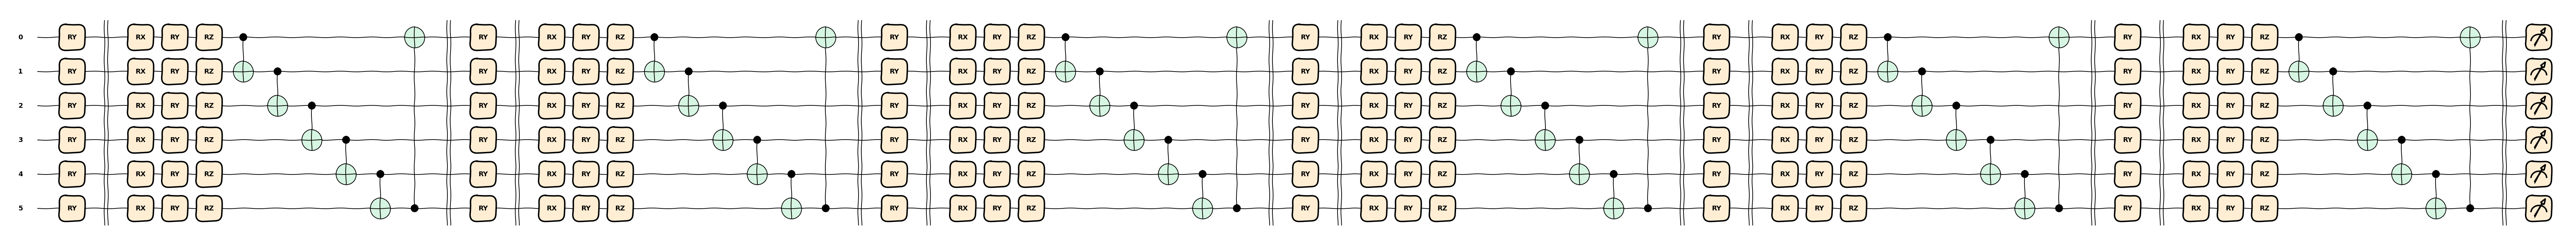

In [5]:
vertical = 3
n_inputs = len(model.scalars) + len(model.angles)
layers = 6

model.push_extra('vertical', vertical)
model.push_extra('n_inputs', n_inputs)
model.push_extra('layers', layers)

model.generate_device(n_inputs * vertical)


def embedding(data, vertical, n_inputs, params):
	for i in range(n_inputs):
		for j in range(vertical):
			if i < len(model.scalars):
				value = data[i]
				name = model.header[i + len(model.consts)]
				(min, max) = model.scalars.get(name).get('range')
				if min == max:
					value = 0.5
				else:
					value = (((value - min) / (max - min)) * 2 - 1) * np.pi
				qml.RY(params[i * vertical + j] * value, wires=i * vertical + j)
			else:
				value = data[i]
				name = model.header[i + len(model.consts)]
				(min, max) = model.angles.get(name).get('range')

				qml.RY(params[i * vertical + j] * data[i], wires=i * vertical + j)

	qml.Barrier()


def rot_ent(params, n_qubits):
	if len(params) < n_qubits * 3:
		raise ValueError('Not enough params')

	for i in range(n_qubits):
		qml.RX(params[3 * i], wires=i)
		qml.RY(params[3 * i + 1], wires=i)
		qml.RZ(params[3 * i + 2], wires=i)

	for i in range(n_qubits):
		qml.CNOT(wires=[i, (i + 1) % n_qubits])

	qml.Barrier()


def _circuit(data, params):
	vertical = model.extra.get('vertical')
	n_inputs = model.extra.get('n_inputs')
	layers = model.extra.get('layers')
	n_qubits = vertical * n_inputs
	for i in range(layers):
		temp_params = params[i * n_qubits * 4 : (i + 1) * n_qubits * 4]
		embedding(data, vertical, n_inputs, temp_params[:n_qubits])

		rot_ent(temp_params[n_qubits:], n_qubits)

	obs = [qml.PauliZ(i) for i in range(n_qubits)]

	return qml.expval(qml.prod(*obs))


def _model(circ, input, params):
	return (circ(input, params) + 1) / 2


model.set_model(_model)
model.set_circuit(_circuit)
model.generate_params((n_inputs * vertical * 4 * layers,))

qml.draw_mpl(model.circuit, style='sketch')(model.train_in, model.params)

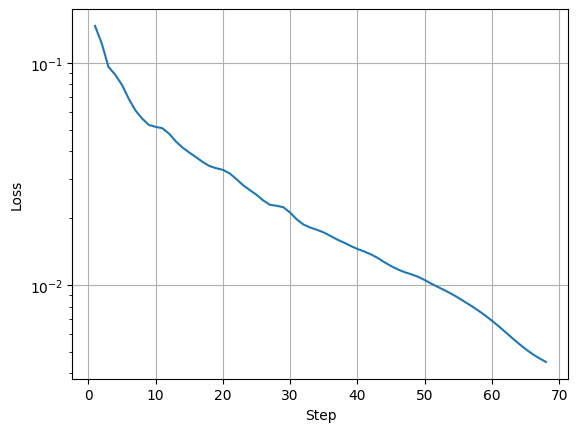

Loss: 0.004503817220128243


KeyboardInterrupt: 

In [6]:
model.set_max_steps(500)
model.set_objective(1E-6)
model.optimization(objective=True, callback= 'graph')

In [ ]:
print('Train score:', model.losses(model.params,model.train_in,model.train_out))

Test score: 0.0012137931655141364


In [ ]:
print('Test score:', model.test())

Test score: 0.0012137931655141364


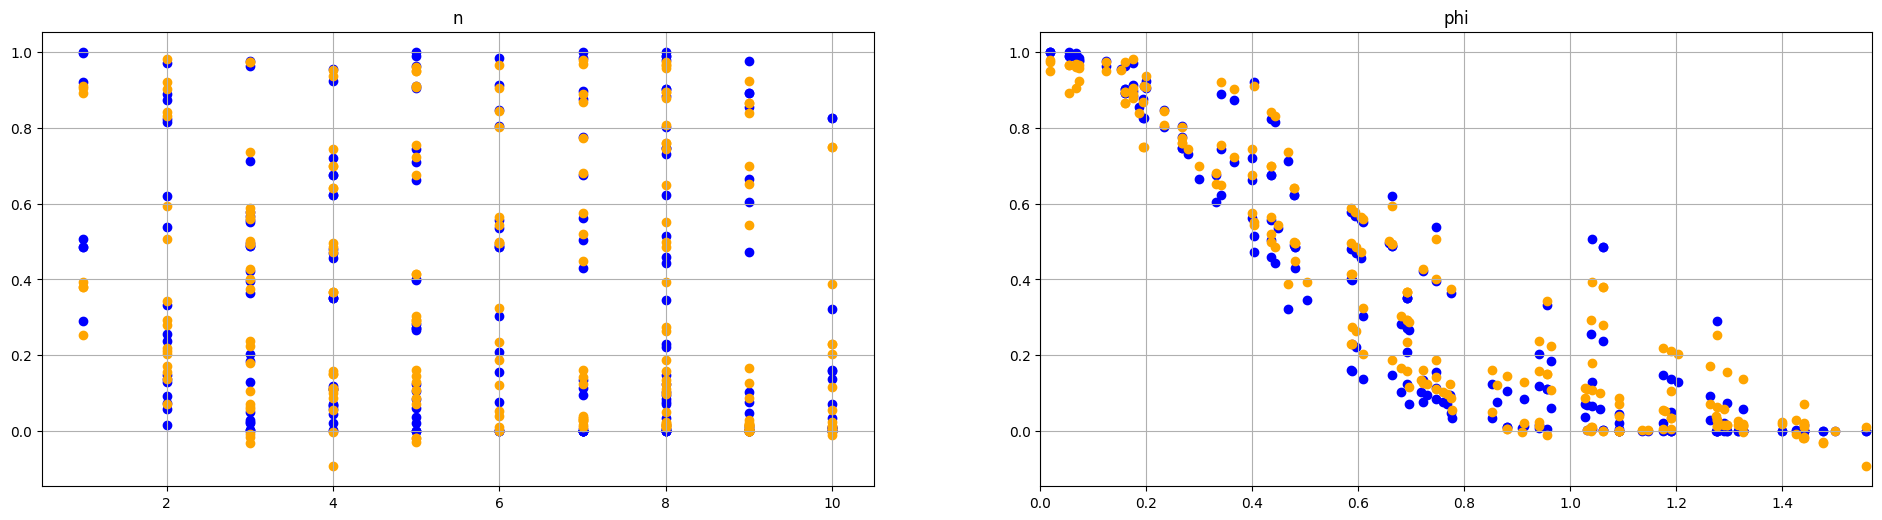

In [ ]:
model.draw_train()

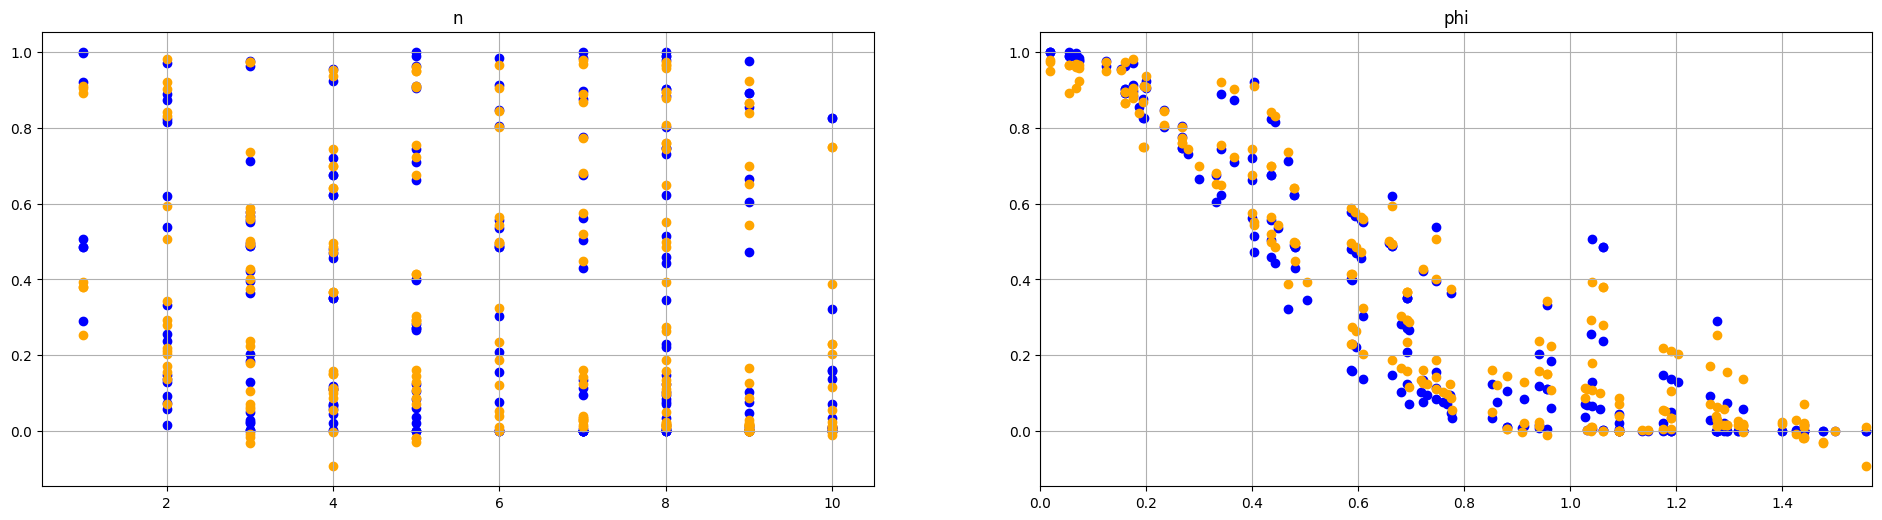

In [ ]:
model.draw()

In [ ]:
model.serialize('models/' + model.name + '.json')